**Variational autoencoder using CNN**


In [ ]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)

11493376/11490434 [==============================] - 3s 0us/step
(60000, 28, 28)


In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, [-1, x_train.shape[1], x_train.shape[1], 1])
x_test = np.reshape(x_test, [-1, x_test.shape[1], x_test.shape[1], 1])

In [ ]:
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# network parameters
input_shape = (x_train.shape[1], x_train.shape[1], 1)
kernel_size = 3
filters = 16
batch_size = 128
latent_dim = 2
epochs = 40

In [ ]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(filters=32,kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=64,kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)

In [ ]:
shape = K.int_shape(x)

In [ ]:
inputs

<tf.Tensor 'encoder_input:0' shape=(None, 28, 28, 1) dtype=float32>

In [ ]:
print(shape)

(None, 7, 7, 64)


In [ ]:
# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [ ]:
# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

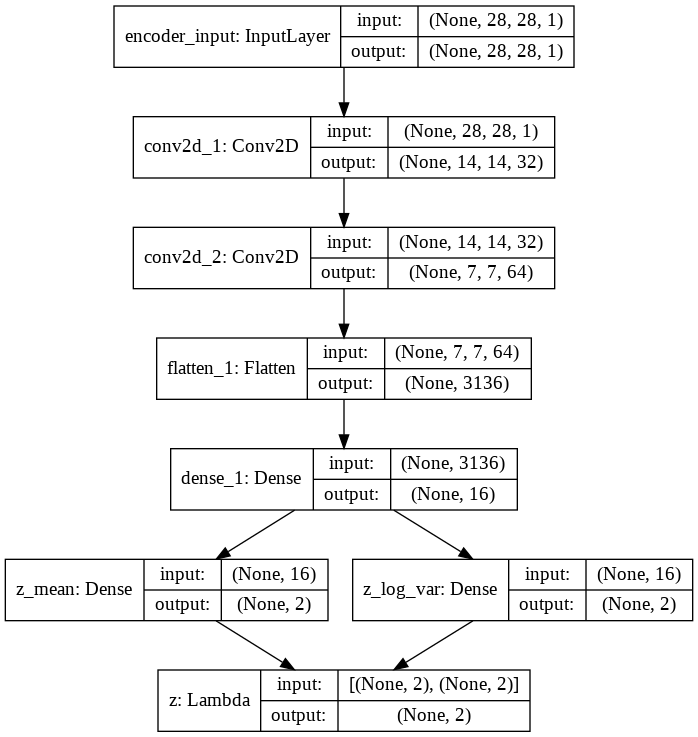

In [ ]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, show_shapes=True)


In [ ]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(filters=64, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(filters=32, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same', name='decoder_output')(x)


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

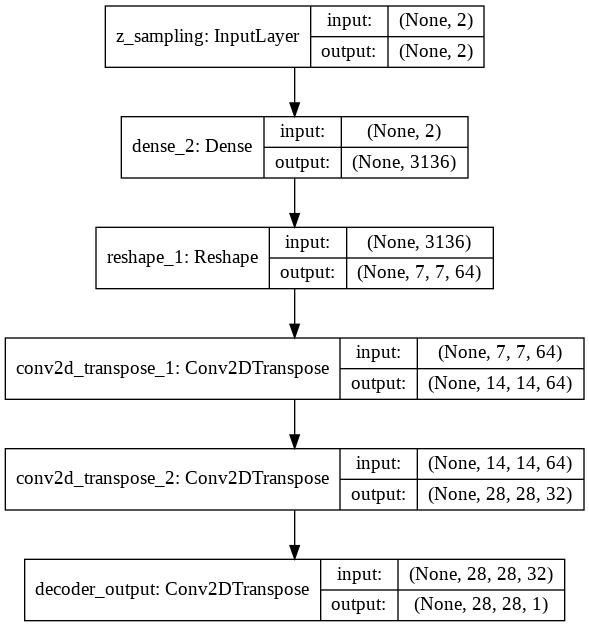

In [ ]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True)

In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [ ]:
models = (encoder, decoder)
data = (x_test, y_test)


In [ ]:
#reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


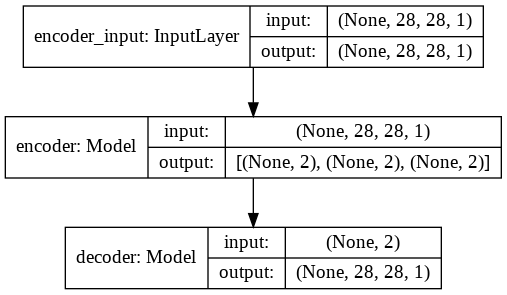

In [ ]:
reconstruction_loss *= x_train.shape[1] * x_train.shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

In [ ]:
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 13s 218us/step - loss: 51.7465 - val_loss: 45.1308
Epoch 2/40
60000/60000 [==============================] - 6s 107us/step - loss: 43.9118 - val_loss: 43.0699
Epoch 3/40
60000/60000 [==============================] - 6s 107us/step - loss: 42.1767 - val_loss: 41.5869
Epoch 4/40
60000/60000 [==============================] - 6s 108us/step - loss: 41.1501 - val_loss: 40.5767
Epoch 5/40
60000/60000 [==============================] - 6s 107us/step - loss: 40.3432 - val_loss: 40.5483
Epoch 6/40
60000/60000 [==============================] - 6s 107us/step - loss: 39.7592 - val_loss: 39.5532
Epoch 7/40
60000/60000 [==============================] - 6s 107us/step - loss: 39.2762 - val_loss: 38.8104
Epoch 8/40
60000/60000 [==============================] - 6s 107us/step - loss: 38.8810 - val_loss: 39.0664
Epoch 9/40
60000/60000 [==============================] - 6s 108us/step - loss: 38.57

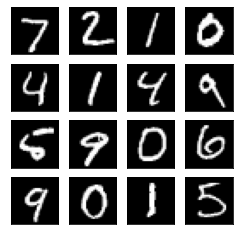

In [ ]:
plt.figure(figsize=(4, 4))
for i in range(16):
    # display original
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


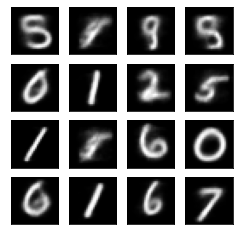

In [ ]:
plt.figure(figsize=(4, 4))
for i in range(16):
    # display original
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(decoder.predict(np.random.normal(size=(1,2))).reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


**REFERENCES:**

[1]. Deep Learning by Ian Goodfellow and Yoshua Bengio and Aaron Courville

[2]. Pattern Recognition and Machine Learning by Christopher Bishop 

[3]. https://keras.io/datasets/

[4]. https://www.tensorflow.org/tutorials/generative/cvae